In [56]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from itertools import product
import quimb.tensor as qtn

# Uploaded code
sys.path.insert(0, "/mnt/data")
from generate_tt import generate_mps

from mps_2d_encoding_tools import (
    break_up_list,
    convert_to_indices,
    fit_bicubic_to_image,
    reconstruct_from_xy,
    reconstruct_image_from_coefficients,
)


In [57]:
# -----------------------------
# Webcam capture
# -----------------------------
DEVICE_INDEX = 0
N_FRAMES = 20
TARGET_SIZE = 256        # must be 4 * 2^k (64, 128, 256, ...)
SHOW_LIVE = True

cap = cv2.VideoCapture(DEVICE_INDEX)
if not cap.isOpened():
    raise RuntimeError("Could not open webcam. Try DEVICE_INDEX=1, or check OS permissions.")

frames_bgr = []
print("Capturing... (press 'q' to stop early)")
for t in range(N_FRAMES):
    ok, frame = cap.read()
    if not ok:
        print(f"Frame read failed at t={t}")
        break
    frames_bgr.append(frame)
    if SHOW_LIVE:
        cv2.imshow("Live webcam (press q to stop)", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
print(f"Captured {len(frames_bgr)} frames.")


Capturing... (press 'q' to stop early)
Captured 20 frames.


In [58]:
def preprocess_frames(frames_bgr, target_size):
    out = []
    for fr in frames_bgr:
        gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (target_size, target_size), interpolation=cv2.INTER_AREA)
        out.append(gray.astype(np.float32) / 255.0)
    return np.stack(out, axis=0)

G = preprocess_frames(frames_bgr, TARGET_SIZE)
T, H, W = G.shape
print("G:", G.shape, "range:", (float(G.min()), float(G.max())))


G: (20, 256, 256) range: (0.0, 0.6313725709915161)


In [59]:
# Validate TARGET_SIZE = 4 * 2^k and define (k, n)
if TARGET_SIZE % 4 != 0:
    raise ValueError("TARGET_SIZE must be divisible by 4 (bicubic 4x4 patches).")
N = TARGET_SIZE // 4
if (N & (N-1)) != 0:
    raise ValueError("TARGET_SIZE/4 must be power of two (TARGET_SIZE = 4*2^k).")
k = int(np.log2(N))
n = k + 2
assert 2**n == TARGET_SIZE
print(f"Derived: k={k}, n={n}, image size={2**n}")


Derived: k=6, n=8, image size=256


In [60]:
# -----------------------------
# 1) Polynomial fit for ALL frames + verification
# -----------------------------
G_poly = np.zeros_like(G, dtype=np.float32)
coeffs_list = []   # store (coefficients, patch_coeffs) per frame

for t in range(T):
    coefficients, _ = fit_bicubic_to_image(G[t], k, show_plot=False)
    _, patch_coeffs = reconstruct_image_from_coefficients(coefficients, k)
    # Reconstruct polynomial image (fast, no MPS)
    # patch_coeffs is dict (i,j)->A; reconstruct_image_from_coefficients already returns an image too,
    # but we rely on the function output image from the helper here:
    img_poly, _ = reconstruct_image_from_coefficients(coefficients, k)
    G_poly[t] = np.clip(img_poly.astype(np.float32), 0.0, 1.0)
    coeffs_list.append((coefficients, patch_coeffs))

def psnr(a, b, eps=1e-12):
    mse = float(np.mean((a-b)**2))
    return 10.0 * np.log10(1.0 / max(mse, eps))

psnr_poly = np.array([psnr(G[t], G_poly[t]) for t in range(T)], dtype=float)
print("Poly fit PSNR mean/min:", float(psnr_poly.mean()), float(psnr_poly.min()))


Poly fit PSNR mean/min: 120.0 120.0


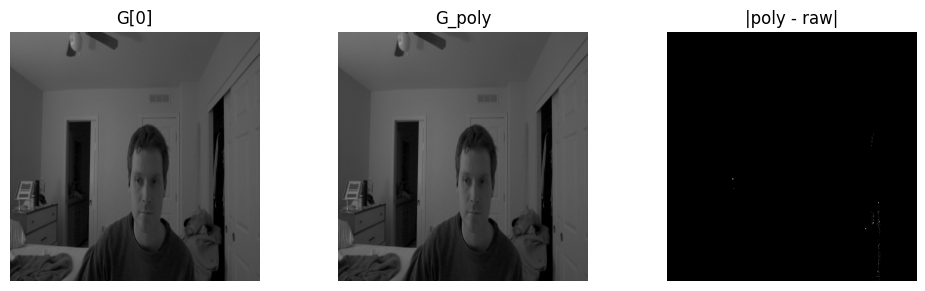

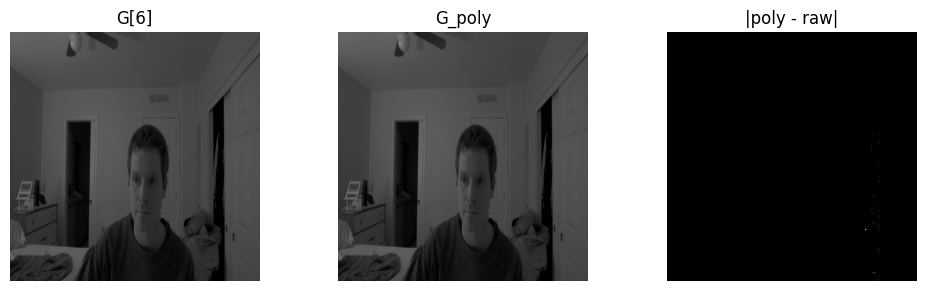

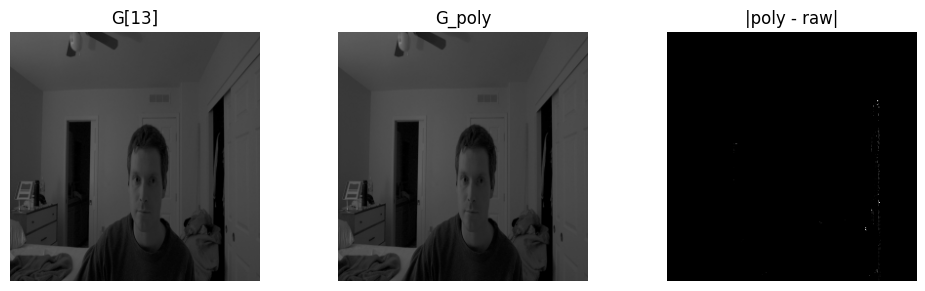

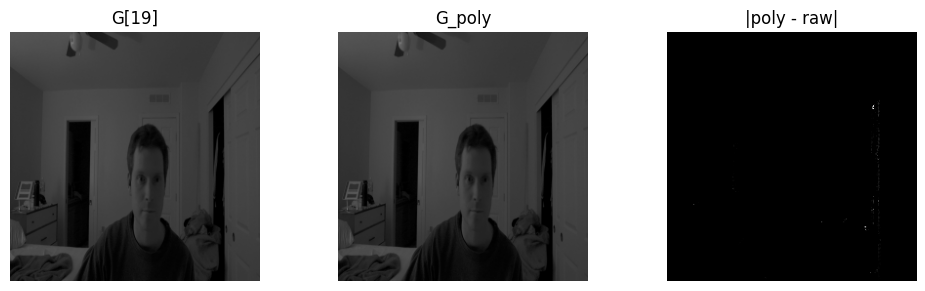

In [61]:
# Show a few poly recon comparisons
def show_poly(t):
    plt.figure(figsize=(10,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(G[t], cmap="gray", vmin=0, vmax=1); ax1.set_title(f"G[{t}]"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(G_poly[t], cmap="gray", vmin=0, vmax=1); ax2.set_title("G_poly"); ax2.axis("off")
    ax3 = plt.subplot(1,3,3); ax3.imshow(np.abs(G_poly[t]-G[t]), cmap="gray"); ax3.set_title("|poly - raw|"); ax3.axis("off")
    plt.tight_layout(); plt.show()

for t in [0, T//3, 2*T//3, T-1]:
    if 0 <= t < T:
        show_poly(t)


In [62]:
# -----------------------------
# 3) Compute deltas from POLY images and verify cumulative identity
# -----------------------------
Delta = np.zeros_like(G_poly, dtype=np.float32)
Delta[1:] = G_poly[1:] - G_poly[:-1]

G_cum = np.zeros_like(G_poly, dtype=np.float32)
G_cum[0] = G_poly[0]
G_cum[1:] = G_poly[0] + np.cumsum(Delta[1:], axis=0)

err = G_cum - G_poly
err_mse = np.mean(err**2, axis=(1,2))
print("Cumsum identity check (poly): MSE min/mean/max =",
      float(err_mse.min()), float(err_mse.mean()), float(err_mse.max()))


Cumsum identity check (poly): MSE min/mean/max = 0.0 2.5008531445409577e-19 8.431220373181496e-19


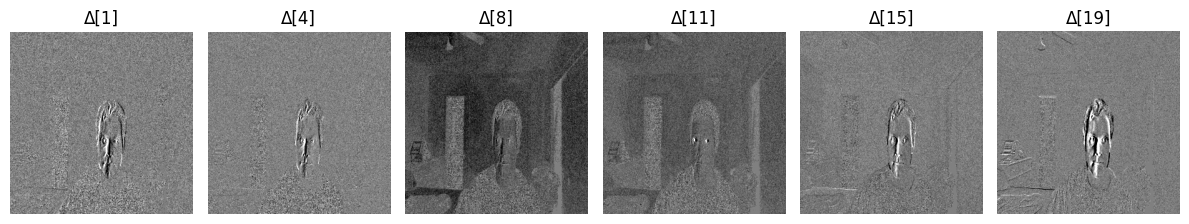

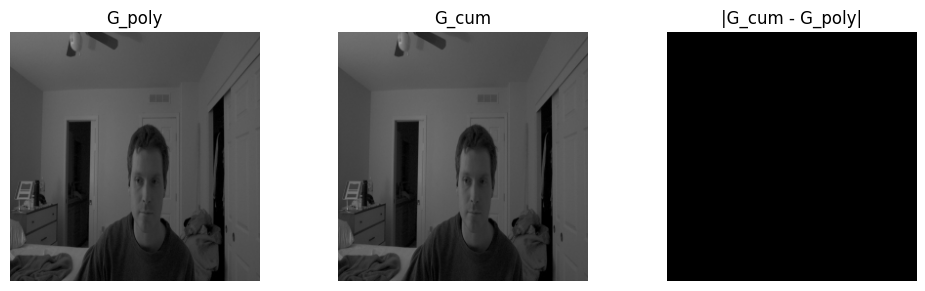

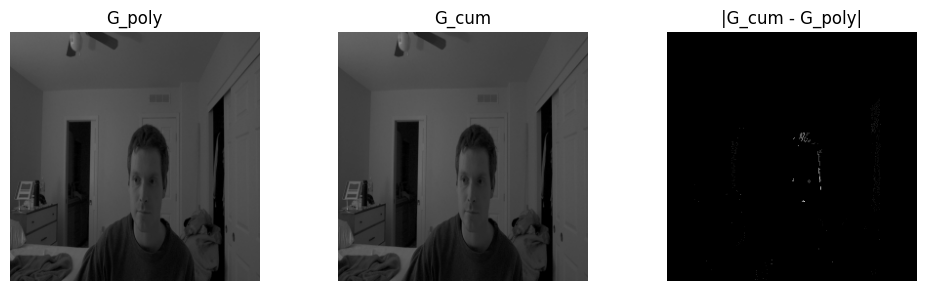

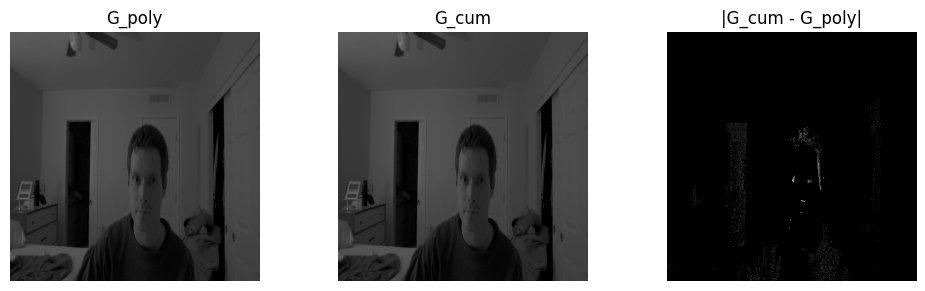

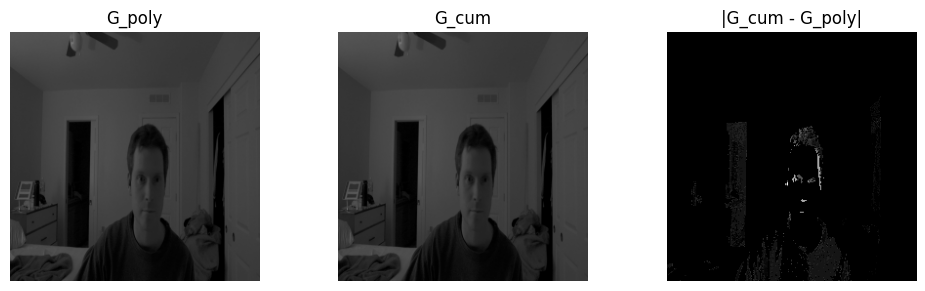

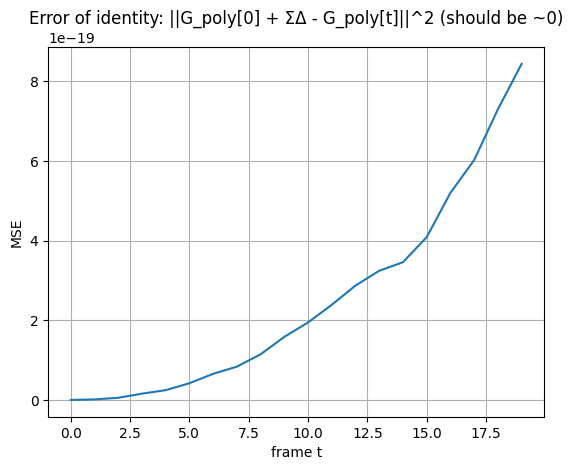

In [63]:
# Plot some delta frames with symmetric contrast
idxs = np.linspace(1, T-1, num=min(6, max(1,T-1)), dtype=int)
v = float(np.percentile(np.abs(Delta[1:]), 99)) if T > 1 else 1.0
v = max(v, 1e-6)

plt.figure(figsize=(12, 2.8))
for kk, t in enumerate(idxs):
    ax = plt.subplot(1, len(idxs), kk+1)
    ax.imshow(Delta[t], cmap="gray", vmin=-v, vmax=v)
    ax.set_title(f"Δ[{t}]")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Plot cumulative reconstruction error images for a few times
def show_cum_err(t):
    plt.figure(figsize=(10,3))
    ax1=plt.subplot(1,3,1); ax1.imshow(G_poly[t], cmap="gray", vmin=0, vmax=1); ax1.set_title("G_poly"); ax1.axis("off")
    ax2=plt.subplot(1,3,2); ax2.imshow(np.clip(G_cum[t],0,1), cmap="gray", vmin=0, vmax=1); ax2.set_title("G_cum"); ax2.axis("off")
    ax3=plt.subplot(1,3,3); ax3.imshow(np.abs(err[t]), cmap="gray"); ax3.set_title("|G_cum - G_poly|"); ax3.axis("off")
    plt.tight_layout(); plt.show()

for t in [0, T//3, 2*T//3, T-1]:
    if 0 <= t < T:
        show_cum_err(t)

plt.figure()
plt.plot(err_mse)
plt.xlabel("frame t"); plt.ylabel("MSE")
plt.title("Error of identity: ||G_poly[0] + ΣΔ - G_poly[t]||^2 (should be ~0)")
plt.grid(True)
plt.show()


In [64]:
# from itertools import product


# # Pick which delta frames to encode as MPS
# DELTA_MPS_TS = list(range(1, min(T, 6)))   # deltas 1..5 by default
# CUTOFF_MPS_DELTA = 1e-8                     # compression during summation
# c, d = 0.0, 1.0

# def bond_dims_quimb(M):
#     """Return r0..rL from quimb MPS tensor shapes (rL, phys, rR)."""
#     ts = M.tensors
#     r = [int(ts[0].data.shape[0])]
#     for t in ts:
#         r.append(int(t.data.shape[-1]))
#     return r

# Delta_MPS = {}  # t -> MPS
# for t in [6]:
#     # Fit bicubic to the delta image
#     coeffs_d, _ = fit_bicubic_to_image(Delta[t], k, show_plot=False)
#     _, patch_coeffs_d = reconstruct_image_from_coefficients(coeffs_d, k)

#     # Build gated patch MPSs and sum (same as your subset-frame MPS logic)
#     mps_list = []
#     for bits in product([0, 1], repeat=2 * k):
#         i, j = convert_to_indices(bits)
#         A = patch_coeffs_d[(i, j)]
#         mps_list.append(get_2d_mps_from_patch(A, n=n, k=k, c=c, d=d, bits=bits))

#     Mtot = add_2d_mps(mps_list, cutoff=CUTOFF_MPS_DELTA)
#     # do NOT normalize, deltas are signed and scaling matters
#     Delta_MPS[t] = Mtot

#     r = bond_dims_quimb(Mtot)
#     print(
#         f"Δ[{t}]  r0..rL={r}  maxbond={max(r)}  "
#     )


In [65]:

def bit_flip(v: int) -> int:
    return abs(1 - v)

def bits_from_ij(i, j, k):
    """Return interleaved bits [x0,y0,x1,y1,...] (MSB->LSB) for gating."""
    xb = [(i >> (k - 1 - b)) & 1 for b in range(k)]
    yb = [(j >> (k - 1 - b)) & 1 for b in range(k)]
    bits = []
    for b in range(k):
        bits.extend([xb[b], yb[b]])
    return bits

def _split_xy_cores_from_generate_mps(mps):
    """generate_mps returns an interleaved core list; break into x-cores and y-cores."""
    pairs = break_up_list([core.data for core in mps])
    x_cores, y_cores = [], []
    for xc, yc in pairs:
        x_cores.append(xc)
        y_cores.append(yc)
    return x_cores, y_cores

def get_2d_mps_from_patch(A, n, k, c, d, bits):
    """
    Build MPS for a single bicubic patch polynomial A (4x4),
    then gate it to the subdomain specified by `bits` (length 2k).
    """
    x_bits = [bit_flip(x) for x in bits[0::2]]
    y_bits = [bit_flip(y) for y in bits[1::2]]

    mps = generate_mps(A, n, c, d)
    x_cores, y_cores = _split_xy_cores_from_generate_mps(mps)

    # Gate first split
    x_cores[0][:, :, x_bits[0]] = 0.0
    y_cores[0][:, y_bits[0]] = 0.0

    # Gate remaining k-1 splits
    for ii in range(1, k):
        x_cores[ii][:, :, x_bits[ii]] = 0.0
        y_cores[ii][:, :, y_bits[ii]] = 0.0

    new_cores = reconstruct_from_xy(xs=x_cores, ys=y_cores)
    return qtn.MatrixProductState(new_cores)

def add_2d_mps(mps_list, cutoff=1e-8):
    """Sum a list of quimb MPS objects with compression."""
    total = mps_list[0]
    for m in mps_list[1:]:
        total.add_MPS(m, inplace=True, compress=True, cutoff=cutoff)
    return total

print("Defined: get_2d_mps_from_patch, add_2d_mps, bits_from_ij")


Defined: get_2d_mps_from_patch, add_2d_mps, bits_from_ij


In [ ]:
# Which delta frames to encode as MPS
DELTA_MPS_TS = [6]                 # change as needed
CHI_MAX_DELTA = 4                 # <-- max bond dimension cap (tune)
COEFF_THRESH = 1e-3                # skip near-zero patches (tune)
MAX_PATCHES = None                 # or set e.g. 128 to cap work

def bond_dims_quimb(M):
    ts = M.tensors
    r = [int(ts[0].data.shape[0])]
    for t in ts:
        r.append(int(t.data.shape[-1]))
    return r

def bits_from_ij(i, j, k):
    xb = [(i >> (k-1-b)) & 1 for b in range(k)]  # MSB->LSB
    yb = [(j >> (k-1-b)) & 1 for b in range(k)]
    bits = []
    for b in range(k):
        bits.extend([xb[b], yb[b]])
    return bits

def patch_score(A):
    return float(np.max(np.abs(A)))

Delta_MPS = {}  # t -> MPS

for t in DELTA_MPS_TS:
    # 1) Fit bicubic to the delta image
    coeffs_d, _ = fit_bicubic_to_image(Delta[t], k, show_plot=False)
    _, patch_coeffs_d = reconstruct_image_from_coefficients(coeffs_d, k)

    # 2) Select nontrivial patches (skip zeros)
    selected = []
    for (i, j), A in patch_coeffs_d.items():
        s = patch_score(A)
        if s > COEFF_THRESH:
            selected.append((s, i, j, A))

    selected.sort(reverse=True, key=lambda x: x[0])
    if MAX_PATCHES is not None:
        selected = selected[:MAX_PATCHES]

    print(f"Δ[{t}] selected {len(selected)}/{len(patch_coeffs_d)} patches "
          f"(COEFF_THRESH={COEFF_THRESH}, MAX_PATCHES={MAX_PATCHES})")

    # 3) Build + add incrementally (compress by max_bond)
    Mtot = None
    for _, i, j, A in selected:
        bits = bits_from_ij(i, j, k)
        Mij = get_2d_mps_from_patch(A, n=n, k=k, c=0, d=1, bits=bits)

        if Mtot is None:
            Mtot = Mij
        else:
            Mtot.add_MPS(
                Mij,
                inplace=True,
                compress=True,
                max_bond=CHI_MAX_DELTA,  # <-- cap bond dimension
                cutoff=0.0               # optional: rely mostly on max_bond
            )

    if Mtot is None:
        print(f"Δ[{t}] all patches skipped; delta MPS is None.")
        Delta_MPS[t] = None
        continue

    Delta_MPS[t] = Mtot
    r = bond_dims_quimb(Mtot)
    print(f"Δ[{t}] r0..rL={r}  maxbond={max(r)} (target cap={CHI_MAX_DELTA})")


Δ[6] selected 4095/4096 patches (COEFF_THRESH=0.001, MAX_PATCHES=None)
Δ[6] r0..rL=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]  maxbond=2 (target cap=4)
